### import packages 

In [ ]:
import numpy as np
import gym
from gym import spaces

import numpy.linalg as LA
import cvxpy as cp
import warnings
from scipy import linalg
import matplotlib.pyplot as plt
!pip install mat4py
from mat4py import loadmat
import cvxpy as cp
import pickle
warnings.filterwarnings('ignore')

# Environment Setup

In [ ]:
# Frequency Control Porblem Environment
class Voltage(gym.Env):
    def  __init__(self, Matrix_X,max_action,dim_action,Penalty_action):
        self.param_gamma=1
        self.Matrix_X = Matrix_X.astype(np.float32)
        self.inv_Matrix_X = LA.inv(Matrix_X).astype(np.float32)
        self.lambda_max = np.max(LA.eigvals(Matrix_X))
        self.max_action=max_action.astype(np.float32)
        self.dim_action=dim_action
        self.state=[]
        self.Penalty_action=Penalty_action

        
    def step(self, action):
        # integrate the state transition dynamics
        self.state=(self.state-action@(self.Matrix_X.T)).copy()
        return self.state
    
    def set_state(self, state_input):
        self.state=state_input


    def reset(self):
        self.state = np.random.uniform(-0.2,0.2,(1,self.dim_action)).astype(np.float32)
        return self.state



### initialize the variables and system matrices





In [ ]:
# Simulation data load from IEEE 33-bus test feeders
data = loadmat('TestCase33.mat')
filename='TestCase'
Matrix_R=data[filename]['R']
Matrix_R=np.asarray(Matrix_R, dtype=np.float32)

Matrix_X=data[filename]['X']
Matrix_X=np.asarray(Matrix_X, dtype=np.float32)

V_ref=data[filename]['V_ref']
V_ref=np.asarray(V_ref, dtype=np.float32)

temp=data[filename]['Q_ref']
Q_ref=np.asarray(temp, dtype=np.float32)

temp=data[filename]['P_ref']
P_ref=np.asarray(temp, dtype=np.float32)

temp=data[filename]['X']
Matrix_X=np.asarray(temp, dtype=np.float32)
Matrix_X=Matrix_X*0.1 # change the base unit to 100kVA
Q_ref=Q_ref*10
P_ref=P_ref*10
Matrix_R = Matrix_R*0.1
X = Matrix_X

In [ ]:


dim_action=np.shape(Matrix_X)[0] #dimension of action space
Penalty_action=0.01
# max_action=np.random.uniform(low=0.01, high=0.05, size=(1,dim_action)) # ramdomly generate max_action for different buses
max_action= np.array([[0.04618363, 0.04674364, 0.03820283, 0.02924964, 0.02933332,
        0.02808668, 0.02881535, 0.04165629, 0.02335836, 0.01319888,
        0.04392617, 0.03839902, 0.01095371, 0.03840252, 0.02673872,
        0.02880578, 0.04716627, 0.02909166, 0.01550123, 0.02202384,
        0.01126694, 0.02100154, 0.01310747, 0.04232934, 0.0467296 ,
        0.01062543, 0.02215125, 0.01564784, 0.01676404, 0.01368452,
        0.0293981 , 0.04056301]])
# V_ref=Matrix_R@P_ref+Matrix_X@Q_ref+np.ones((dim_action,1))
V_ref = np.ones((dim_action,1))
Q_ref = -(LA.inv(Matrix_X))@Matrix_R@P_ref
env = Voltage(Matrix_X,max_action,dim_action,Penalty_action)

# check voltage
Matrix_R@P_ref+Matrix_X@Q_ref+np.ones((dim_action,1))

array([[0.99999999],
       [0.99999995],
       [0.99999992],
       [0.99999989],
       [0.99999977],
       [0.9999997 ],
       [0.99999967],
       [0.9999996 ],
       [0.99999952],
       [0.99999952],
       [0.99999951],
       [0.99999952],
       [0.99999953],
       [0.99999954],
       [0.99999955],
       [0.99999955],
       [0.99999956],
       [0.99999999],
       [0.99999999],
       [0.99999999],
       [0.99999999],
       [0.99999995],
       [0.99999995],
       [0.99999995],
       [0.99999977],
       [0.99999977],
       [0.99999975],
       [0.99999974],
       [0.99999974],
       [0.99999971],
       [0.9999997 ],
       [0.99999971]])

# Optimize Lipschitz bounds

In [ ]:
Matrix_X_inv=np.linalg.inv(Matrix_X)

In [ ]:
# weights are adjusted based on the how far the controller is bounded by the Lipschitz bounds
weight_bound = np.ones(dim_action)
weight_bound[4:18] = 5
weight_bound[24:32] = 3
weight_bound[15:18] = 7

# optimize Lipschitz bounds
K_bound=cp.Variable(dim_action)
objective = cp.Maximize(cp.sum(weight_bound*cp.log(K_bound)))
diag_K_bound = cp.diag(K_bound)
constraints = [(diag_K_bound -2*Matrix_X_inv)<<0,diag_K_bound>>0]

prob = cp.Problem(objective, constraints)
result = prob.solve()
print('status',prob.status)
print('K_bound',K_bound.value)


status optimal
K_bound [65.72077682  4.40483572  2.06182327  1.18981023  1.73967182  1.13642717
  1.00283896  0.73556104  0.57955091  0.56960334  0.55374626  0.44876686
  0.40580849  0.38285314  0.36567041  0.46254471  0.45503718 92.94721977
  3.93182382  3.23640471  2.73879866  3.61377679  2.79636655  2.49903346
  0.99953707  0.95047338  0.74084864  0.64503373  0.62061459  0.56019153
  0.54651148  0.53684872]


In [ ]:
K_bound=np.array(K_bound.value)

# Decentralized Policy Gradient 



In [ ]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow_probability as tfp


### layer setup

In [ ]:
#layer for linear controller
class SimpleDense(Layer):
  def __init__(self, units=2, K_bound_i=1):
      super(SimpleDense, self).__init__()
      self.units = units
      self.lambda_max = tf.constant(env.lambda_max,dtype=tf.float32) 
      self.bound_slop = tf.constant(K_bound_i,dtype=tf.float32)

  def build(self, input_shape):  
    # Create the state of the layer (weights)
    w_init = tf.random_uniform_initializer(minval=0.01, maxval=0.1)
    self.w = tf.Variable(
        initial_value=w_init(shape=(input_shape[-1],),
                             dtype='float32'),
        constraint=tf.keras.constraints.NonNeg(),                 
        trainable=True)
    
  def call(self, inputs):  
    # Defines the computation from inputs to outputs
    # linear_K_=tf.math.minimum(self.w, 2/self.lambda_max)
    linear_K_=tf.math.minimum(self.w, self.bound_slop)
    return K.dot(inputs, tf.linalg.diag(linear_K_))

#layer for nonlinear controller
class PiecewiseNonlinear(Layer):
  def __init__(self, units=2, internal_units=20,K_bound_i=1 ):
      super(PiecewiseNonlinear, self).__init__()
      self.units = units
      self.action_units = units # for this application, action_units = number of states
      self.internal_units = internal_units  # how much pieces are included in the piece-wise linear function
      self.lambda_max = tf.constant(env.lambda_max,dtype=tf.float32) 
      self.w_recover = tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                +2*tf.eye(internal_units),dtype=tf.float32)
      self.b_recover = tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                      -tf.eye(internal_units),dtype=tf.float32)
      self.ones_frequency = tf.ones((self.action_units,internal_units),dtype=tf.float32)
      self.bound_slop = tf.constant(K_bound_i*np.ones((1,internal_units)),dtype=tf.float32)

  def build(self, input_shape):  # Create the state of the layer (weights)
      self.w_plus_temp0= self.add_weight(
          shape=(self.action_units,self.internal_units),
          initializer=tf.keras.initializers.RandomUniform(minval=0.05, maxval=0.2),
          # initializer='uniform',
          trainable=True,
          name='w_plus_temp')

      self.b_plus_temp0 = self.add_weight(
          shape=(self.action_units,self.internal_units),
          initializer=tf.keras.initializers.RandomUniform(minval=0.02, maxval=0.1),
          trainable=True,
          constraint=tf.keras.constraints.MaxNorm(0.3),
          name='b_plus_temp')
      self.w_minus_temp0= self.add_weight(
          shape=(self.action_units,self.internal_units),
          initializer=tf.keras.initializers.RandomUniform(minval=0.05, maxval=0.2),
          # initializer='uniform',
          trainable=True,
          name='w_minus_temp')

      self.b_minus_temp0 = self.add_weight(
          shape=(self.action_units,self.internal_units),
          initializer=tf.keras.initializers.RandomUniform(minval=0.02, maxval=0.1),
          trainable=True,
          constraint=tf.keras.constraints.MaxNorm(0.3),
          name='b_minus_temp')
      self.built = True
    
  def call(self, inputs):  # Defines the computation from inputs to outputs
      # here input should be the shape of (batch, state)
      w_plus_temp=tf.math.minimum(tf.math.abs(self.w_plus_temp0), self.bound_slop)
      b_plus_temp=tf.math.abs(self.b_plus_temp0)
      w_minus_temp=tf.math.minimum(tf.math.abs(self.w_minus_temp0), self.bound_slop)
      b_minus_temp=tf.math.abs(self.b_minus_temp0)

      w_plus=K.dot(w_plus_temp,self.w_recover)
      b_plus=K.dot(-b_plus_temp,self.b_recover)
      w_minus=K.dot(-w_minus_temp,self.w_recover)
      b_minus=K.dot(-b_minus_temp,self.b_recover)

      nonlinear_plus=K.sum(K.relu(K.dot(tf.linalg.diag(inputs),self.ones_frequency)+b_plus)\
                      *w_plus,axis=2)  
      nonlinear_minus=K.sum(K.relu(-K.dot(tf.linalg.diag(inputs),self.ones_frequency)+b_minus)\
                      *w_minus,axis=2)  

      action_nonconstrain= nonlinear_plus+nonlinear_minus

      return action_nonconstrain


In [ ]:
#Initialize model for actor

def decentralized_get_actor(K_bound_i, controller_type='nonlinear'):
    inputs = layers.Input(shape=(1,))
    if controller_type=='nonlinear':
        outputs = PiecewiseNonlinear(1, 20, K_bound_i)(inputs)
    if controller_type=='linear':
        outputs = SimpleDense(tf.shape(inputs), K_bound_i)(inputs)

    model = tf.keras.Model(inputs, outputs)
    return model


In [ ]:
#Policy gradient algorithum for training neural network cotrnoller

tf.config.run_functions_eagerly(True)
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

@tf.function
def Train_PG(mu_agent, optimizer_agent, sigma_e, max_action, Trajectory_record, Action_record, reward_record, agent_ind):
    reward_record=reward_record-np.mean(reward_record)
    with tf.GradientTape() as tape:
        sum_log_prob=tf.zeros(len(reward[:,agent_ind]),dtype=tf.float32)
        for i in range(0,len(Trajectory_record)):
            mu_batch=mu_agent(Trajectory_record[i])
            sigma_e = tf.dtypes.cast(sigma_e, tf.float32)
            
            ones = tf.ones((tf.shape(mu_batch)),dtype=tf.float32)
            max_action = tf.dtypes.cast(max_action, tf.float32)
            normal_dist = tfp.distributions.MultivariateNormalDiag(loc=mu_batch, \
                            scale_diag=sigma_e*ones*max_action)  
            log_prob = normal_dist.log_prob(Action_record[i].reshape(tf.shape(mu_batch)))
            sum_log_prob+=log_prob
        loss = -tf.reduce_mean(sum_log_prob * reward_record)
        grads_mu = tape.gradient(loss, mu_agent.trainable_weights)
        optimizer_agent.apply_gradients(zip(grads_mu, mu_agent.trainable_weights))
    return loss


In [ ]:
# implement gaussian policy

def decentralized_policy(state_i, actor_model_i, sigma_e, action_upper_bound, action_lower_bound):
    mu_e = actor_model_i(state_i)
    normal_dist = tfp.distributions.Normal(mu_e, sigma_e*tf.ones((tf.shape(state_i)[0],1),dtype=tf.float32)*action_upper_bound)
    sampled_actions_i = normal_dist.sample(1)

    # We make sure action is within bounds
    legal_action_i = tf.clip_by_value(sampled_actions_i, action_lower_bound, action_upper_bound)
    return tf.squeeze(legal_action_i)


### training nonlinear

In [ ]:
# generate agents in each bus

total_episodes = 500

T = 10
# Discount factor for future rewards
gamma = 1
# Used to update target networks
alpha = env.Penalty_action
n = dim_action

global_step = tf.Variable(0, trainable=False)
actor_lr_initial = 0.0025
actor_decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    actor_lr_initial, 100, 0.6, staircase=True)

actor_model_list = []
actor_optimizer_list = []
for i in range(n):
  actor_model_i = decentralized_get_actor(K_bound[i])
  actor_optimizer_i =  tf.keras.optimizers.Adam(learning_rate=actor_decayed_lr)
  actor_model_list.append(actor_model_i)  
  actor_optimizer_list.append(actor_optimizer_i)



In [ ]:
## generate the same test set for comparing
# import pickle
# initial_state_q = (1- np.random.uniform(-Q_init_ratio,Q_init_ratio,(Intial_Batch_num,n)))*(Q_ref.T)
# initial_state_p = (1- np.random.uniform(-P_init_ratio,P_init_ratio,(Intial_Batch_num,n)))*(P_ref.T)
# initial_state_test=initial_state_p@Matrix_R.T+initial_state_q@Matrix_X.T

# f = open('/content/drive/MyDrive/Colab Notebooks/voltage control/policy gradient/weights/bus33/initial_state_test.pckl', 'wb')
# pickle.dump([initial_state_test], f)
# f.close()

In [ ]:
## load the generated test set for comparing

f = open('/content/drive/MyDrive/Colab Notebooks/voltage control/policy gradient/weights/bus33/initial_state_test.pckl', 'rb')
[initial_state_test]= pickle.load(f)
f.close()

In [ ]:

Intial_Batch_num = 500

sigma_e0 = 0.5*np.ones(n) # initial standard deciation for Gaussian policy
action_upper_bound = env.max_action.reshape(-1)
action_lower_bound = -env.max_action.reshape(-1)
actor_loss = np.zeros(n)
record_loss = []
record_loss_test = []
Q_init_ratio = 0.7
P_init_ratio = 0.7

action = np.zeros((Intial_Batch_num, n))


for ep in range(total_episodes):
    Action_record_dict = {}
    Trajectory_record_dict = {}
    for agent_ind in range(n):
        Action_record_dict[agent_ind] = []
        Trajectory_record_dict[agent_ind] = []
    initial_state_q = (1- np.random.uniform(-Q_init_ratio,Q_init_ratio,(Intial_Batch_num,n)))*(Q_ref.T)
    initial_state_p = (1- np.random.uniform(-P_init_ratio,P_init_ratio,(Intial_Batch_num,n)))*(P_ref.T)
    initial_state=initial_state_p@Matrix_R.T+initial_state_q@Matrix_X.T
    prev_state = initial_state.copy()
    reward = np.zeros((Intial_Batch_num, n))
    sigma_e = sigma_e0*np.exp(-ep/100)
    sigma_e.astype('float32')
    # Collect trajectory in T steps
    for t in range(T):
        for agent_ind in range(n):
            Trajectory_record_dict[agent_ind].append (prev_state[:,agent_ind])
            action_i = decentralized_policy(prev_state[:,agent_ind].reshape((-1,1)), actor_model_list[agent_ind], sigma_e[agent_ind],\
                                                     action_upper_bound[agent_ind], action_lower_bound[agent_ind])
            action[:,agent_ind] = action_i
            Action_record_dict[agent_ind].append (action_i)       
        state = tf.subtract(prev_state, tf.matmul(action, (X.T)))
        reward += -abs(state) - alpha * abs(action)
        prev_state = state.numpy().astype('float32')
    
    # Train each agent decentralizedly
    for agent_ind in range(n):
        Train_PG(actor_model_list[agent_ind], actor_optimizer_list[agent_ind], sigma_e[agent_ind], \
                                         action_upper_bound[agent_ind], Trajectory_record_dict[agent_ind], Action_record_dict[agent_ind],\
                                         reward[:,agent_ind], agent_ind)
    record_loss.append(np.mean(reward,axis=0))


    # calculate cost on the test set
    prev_state = initial_state_test.copy()
    reward = np.zeros((Intial_Batch_num, n))
    for t in range(T):
        for agent_ind in range(n):
            action[:,agent_ind] = decentralized_policy(prev_state[:,agent_ind].reshape((-1,1)), actor_model_list[agent_ind], 0*sigma_e[agent_ind],\
                                                      action_upper_bound[agent_ind], action_lower_bound[agent_ind]) #actor_model_list[agent_ind]( np.array([prev_state[agent_ind]]) , training=True) 
        state = prev_state - action @ (X.T)
        prev_state = state.copy()
        reward += -abs(state) - alpha * abs(action)
    record_loss_test.append(np.mean(reward,axis=0))


    if ep % 1 == 0:
      print('#################################################################')
      for agent_ind in range(n):
            print("Episode * {} * actor_loss for {}th agent is ==> train {} test  {}  ".format(ep, agent_ind, record_loss[ep][agent_ind], record_loss_test[ep][agent_ind]))



Streaming output truncated to the last 5000 lines.
Episode * 348 * actor_loss for 15th agent is ==> train -0.017798522777244648 test  -0.01581080444007518  
Episode * 348 * actor_loss for 16th agent is ==> train -0.018882954897118793 test  -0.016788813239851895  
Episode * 348 * actor_loss for 17th agent is ==> train -0.0012980126572928233 test  -0.001287721120724811  
Episode * 348 * actor_loss for 18th agent is ==> train -0.003846248826756516 test  -0.0036222439876887895  
Episode * 348 * actor_loss for 19th agent is ==> train -0.003984087902594827 test  -0.003724340534209486  
Episode * 348 * actor_loss for 20th agent is ==> train -0.004280417011539132 test  -0.004046122537032312  
Episode * 348 * actor_loss for 21th agent is ==> train -0.009718916048515526 test  -0.009812998499848527  
Episode * 348 * actor_loss for 22th agent is ==> train -0.017354572007863212 test  -0.017560349548989426  
Episode * 348 * actor_loss for 23th agent is ==> train -0.021655812851916353 test  -0.022712

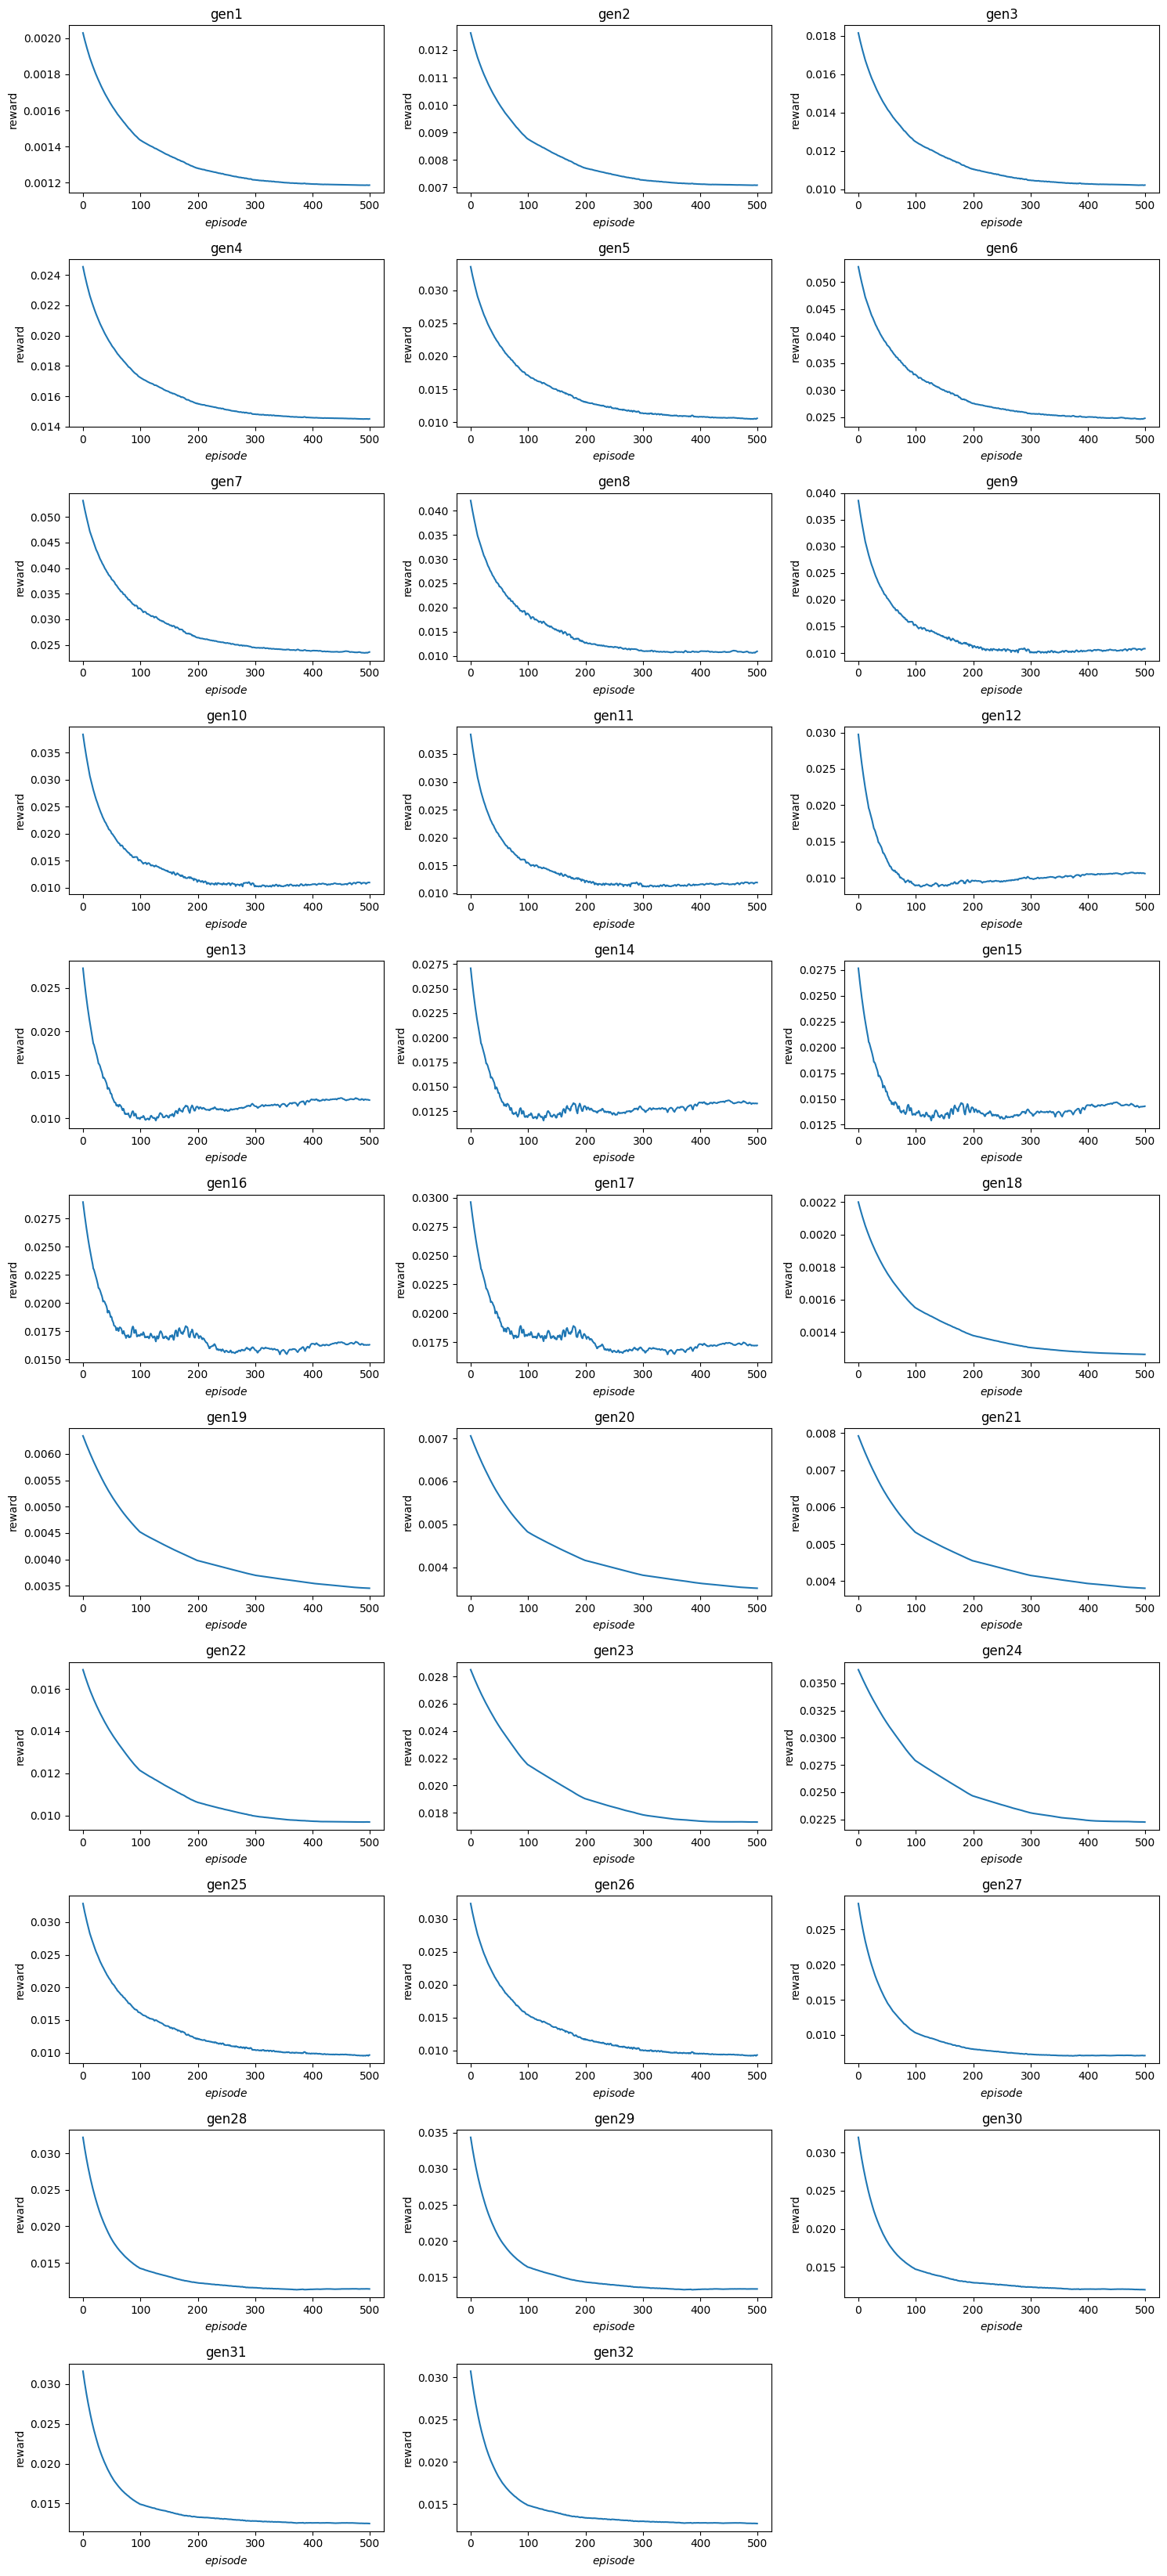

In [ ]:
record_loss_test = np.array(record_loss_test)
fig=plt.figure(figsize=(15,int(np.ceil(n/3))*3), dpi=100)
plt.subplot(2,2,1)
for idx_plot in range(n):
    gen_idx=idx_plot
    plt.subplot(np.ceil(n/3),3,idx_plot+1)
    plt.plot(-record_loss_test[:,idx_plot])
    plt.title('gen'+str(idx_plot+1))
    plt.xlabel('$episode$')
    plt.ylabel('reward') 
fig.tight_layout()    


## train linear for comparison

In [ ]:
# generate agents in each bus


global_step = tf.Variable(0, trainable=False)

actor_lr_initial = 0.0025
actor_decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    actor_lr_initial, 50, 0.6, staircase=True)

linear_actor_model_list = []
actor_optimizer_list = []
for i in range(n):
  actor_model_i = decentralized_get_actor(K_bound[i], controller_type='linear')
  actor_optimizer_i =  tf.keras.optimizers.Adam(learning_rate=actor_decayed_lr)
  linear_actor_model_list.append(actor_model_i)  
  actor_optimizer_list.append(actor_optimizer_i)



In [ ]:

actor_loss = np.zeros(n)
record_loss_linear = []
record_loss_linear_test = []

action = np.zeros((Intial_Batch_num, n))


for ep in range(total_episodes):
    Action_record_dict = {}
    Trajectory_record_dict = {}
    for agent_ind in range(n):
        Action_record_dict[agent_ind] = []
        Trajectory_record_dict[agent_ind] = []
    initial_state_q = (1- np.random.uniform(-Q_init_ratio,Q_init_ratio,(Intial_Batch_num,n)))*(Q_ref.T)
    initial_state_p = (1- np.random.uniform(-P_init_ratio,P_init_ratio,(Intial_Batch_num,n)))*(P_ref.T)
    initial_state=initial_state_p@Matrix_R.T+initial_state_q@Matrix_X.T
    prev_state = initial_state.copy()
    reward = np.zeros((Intial_Batch_num, n))
    sigma_e = sigma_e0*np.exp(-ep/100)
    sigma_e.astype('float32')
    # Collect trajectory in T steps
    for t in range(T):
        for agent_ind in range(n):
            Trajectory_record_dict[agent_ind].append (prev_state[:,agent_ind])
            action_i = decentralized_policy(prev_state[:,agent_ind].reshape((-1,1)), linear_actor_model_list[agent_ind], sigma_e[agent_ind],\
                                                     action_upper_bound[agent_ind], action_lower_bound[agent_ind])
            action[:,agent_ind] = action_i
            Action_record_dict[agent_ind].append (action_i)       
        state = tf.subtract(prev_state, tf.matmul(action, (X.T)))
        reward += -abs(state) - alpha * abs(action)
        prev_state = state.numpy().astype('float32')

    # Train each agent decentralizedly   
    for agent_ind in range(n):
        Train_PG(linear_actor_model_list[agent_ind], actor_optimizer_list[agent_ind], sigma_e[agent_ind], \
                                         action_upper_bound[agent_ind], Trajectory_record_dict[agent_ind], Action_record_dict[agent_ind],\
                                         reward[:,agent_ind], agent_ind)
    record_loss_linear.append(np.mean(reward,axis=0))


    # calculate cost on the test set
    prev_state = initial_state_test.copy()
    reward = np.zeros((Intial_Batch_num, n))
    for t in range(T):
        for agent_ind in range(n):
            action[:,agent_ind] = decentralized_policy(prev_state[:,agent_ind].reshape((-1,1)), linear_actor_model_list[agent_ind], 0*sigma_e[agent_ind],\
                                                      action_upper_bound[agent_ind], action_lower_bound[agent_ind]) #actor_model_list[agent_ind]( np.array([prev_state[agent_ind]]) , training=True) 
        state = prev_state - action @ (X.T)
        prev_state = state.copy()
        reward += -abs(state) - alpha * abs(action)
    record_loss_linear_test.append(np.mean(reward,axis=0))


    if ep % 10 == 0:
      print('#################################################################')
      for agent_ind in range(n):
            print("Episode * {} * actor_loss for {}th agent is ==> train {} test  {} "\
                  .format(ep, agent_ind, record_loss_linear[ep][agent_ind], record_loss_linear_test[ep][agent_ind]))



#################################################################
Episode * 0 * actor_loss for 0th agent is ==> train -0.00611806578220402 test  -0.00250137683048098 
Episode * 0 * actor_loss for 1th agent is ==> train -0.027549113787392214 test  -0.015638714835116647 
Episode * 0 * actor_loss for 2th agent is ==> train -0.03978939418342874 test  -0.023121752107709323 
Episode * 0 * actor_loss for 3th agent is ==> train -0.05236019308543867 test  -0.03139148055181205 
Episode * 0 * actor_loss for 4th agent is ==> train -0.0931358925192143 test  -0.04929381888634331 
Episode * 0 * actor_loss for 5th agent is ==> train -0.12365566592951638 test  -0.071722277785483 
Episode * 0 * actor_loss for 6th agent is ==> train -0.13122709138035882 test  -0.07376728400831846 
Episode * 0 * actor_loss for 7th agent is ==> train -0.15061161661562272 test  -0.06613871321918859 
Episode * 0 * actor_loss for 8th agent is ==> train -0.1682542399516387 test  -0.06361209020224336 
Episode * 0 * actor_loss f

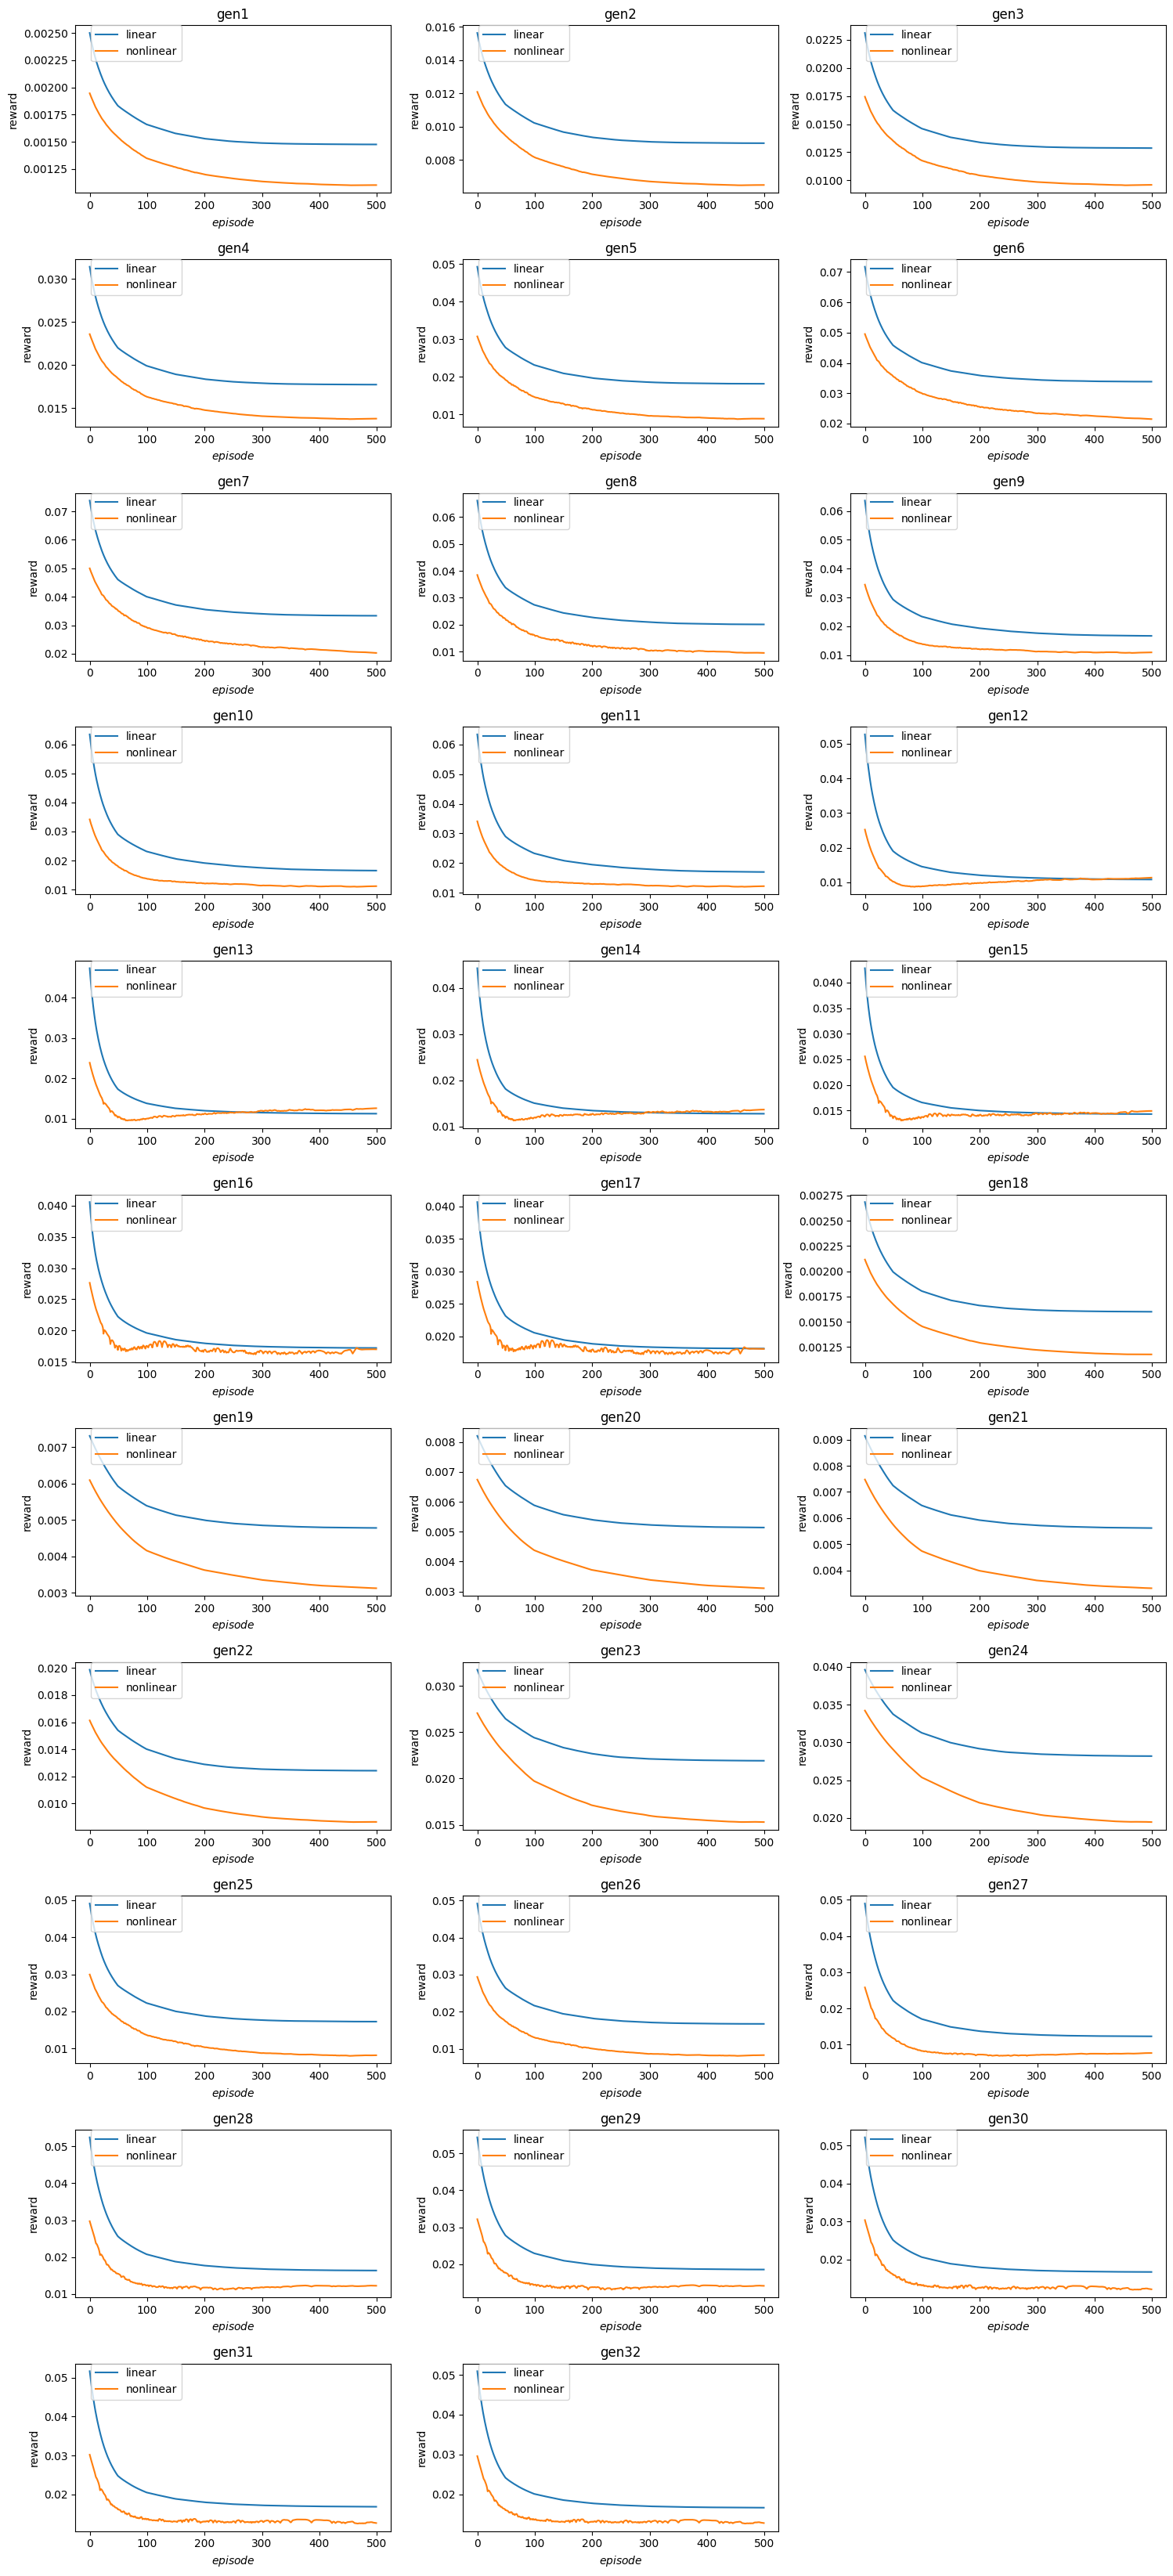

In [ ]:
record_loss_linear_test = np.array(record_loss_linear_test)

fig=plt.figure(figsize=(15,int(np.ceil(n/3))*3), dpi=100)
plt.subplot(2,2,1)
for idx_plot in range(n):
    gen_idx=idx_plot
    plt.subplot(np.ceil(n/3),3,idx_plot+1)
    plt.plot(-record_loss_linear_test[:,idx_plot], label = "linear")
    plt.plot(-record_loss_test[:,idx_plot], label = "nonlinear")
    plt.title('gen'+str(idx_plot+1))
    plt.xlabel('$episode$')
    plt.ylabel('reward') 
    plt.legend(bbox_to_anchor=(0.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()    



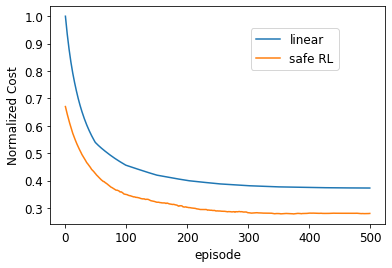

In [ ]:
fontsize_set=12
fontsize_tick=12
plt.plot(np.sum(record_loss_linear_test, axis=1)/np.min(np.sum(record_loss_linear_test, axis=1)), label = "linear")
plt.plot(np.sum(record_loss_test, axis=1)/np.min(np.sum(record_loss_linear_test, axis=1)), label = "safe RL")
plt.xlabel('episode',fontsize=fontsize_set)
plt.ylabel('Normalized Cost',fontsize=fontsize_set) 
plt.xticks(fontsize= fontsize_tick)
plt.yticks(fontsize= fontsize_tick)
plt.legend(bbox_to_anchor=(0.6, 0.9), loc='upper left', borderaxespad=0.,fontsize=fontsize_set)


## comparison and analysis

In [ ]:
Intial_Batch_num = 500
initial_state_q = (1- np.random.uniform(-Q_init_ratio,Q_init_ratio,(Intial_Batch_num,n)))*(Q_ref.T)
initial_state_p = (1- np.random.uniform(-P_init_ratio,P_init_ratio,(Intial_Batch_num,n)))*(P_ref.T)
initial_state=initial_state_p@Matrix_R.T+initial_state_q@Matrix_X.T

In [ ]:
# average reward of non-linear
actor_loss = np.zeros(n)
record_loss = []

action = np.zeros((Intial_Batch_num, n))
prev_state = initial_state.copy()
reward = np.zeros((Intial_Batch_num, n))
sigma_e = sigma_e0*np.exp(-ep/100)
for t in range(T):
    for agent_ind in range(n):
        action[:,agent_ind] = decentralized_policy(prev_state[:,agent_ind].reshape((-1,1)), actor_model_list[agent_ind], 0*sigma_e[agent_ind],\
                                                  action_upper_bound[agent_ind], action_lower_bound[agent_ind]) #actor_model_list[agent_ind]( np.array([prev_state[agent_ind]]) , training=True) 
    state = prev_state - action @ (X.T)
    prev_state = state.copy()
    reward += -abs(state) - alpha * abs(action)

print('reward for nonlinear', np.mean(reward,axis=0))
print('total reward for nonlinear', np.sum(np.mean(reward,axis=0)))



reward for nonlinear [-0.00115886 -0.00667497 -0.00972665 -0.0139821  -0.0110862  -0.0253464
 -0.02344298 -0.01092709 -0.01117414 -0.01132717 -0.0122147  -0.01118716
 -0.01258163 -0.0138827  -0.015047   -0.0172691  -0.01817447 -0.00123813
 -0.0038033  -0.00377084 -0.00401646 -0.00903704 -0.01689207 -0.02161069
 -0.01028121 -0.01015741 -0.00737213 -0.01110078 -0.01287486 -0.0117299
 -0.01228162 -0.01260663]
total reward for nonlinear -0.37397638698591534


In [ ]:
# average reward of linear

actor_loss = np.zeros(n)
record_loss = []
action = np.zeros((Intial_Batch_num, n))

prev_state = initial_state.copy()
reward = np.zeros((Intial_Batch_num, n))
sigma_e = sigma_e0*np.exp(-ep/100)
for t in range(T):
    for agent_ind in range(n):
        action[:,agent_ind] = decentralized_policy(prev_state[:,agent_ind].reshape((-1,1)), linear_actor_model_list[agent_ind], 0*sigma_e[agent_ind],\
                                                  action_upper_bound[agent_ind], action_lower_bound[agent_ind]) #actor_model_list[agent_ind]( np.array([prev_state[agent_ind]]) , training=True) 
    state = prev_state - action @ (X.T)
    prev_state = state.copy()
    reward += -abs(state) - alpha * abs(action)

print('reward for linear', np.mean(reward,axis=0))
print('total reward for linear', np.sum(np.mean(reward,axis=0)))



reward for linear [-0.00143487 -0.0085258  -0.01230202 -0.01728721 -0.01904598 -0.03478949
 -0.033478   -0.02060035 -0.01737712 -0.01714119 -0.01741701 -0.01145148
 -0.01179587 -0.01334491 -0.01505458 -0.01827813 -0.01922075 -0.00155449
 -0.00524137 -0.00553128 -0.00594886 -0.0116816  -0.02136349 -0.02735882
 -0.01827434 -0.01796047 -0.01310864 -0.01618522 -0.01813715 -0.01626033
 -0.01641476 -0.01628997]
total reward for linear -0.49985555810119475


## visualize action

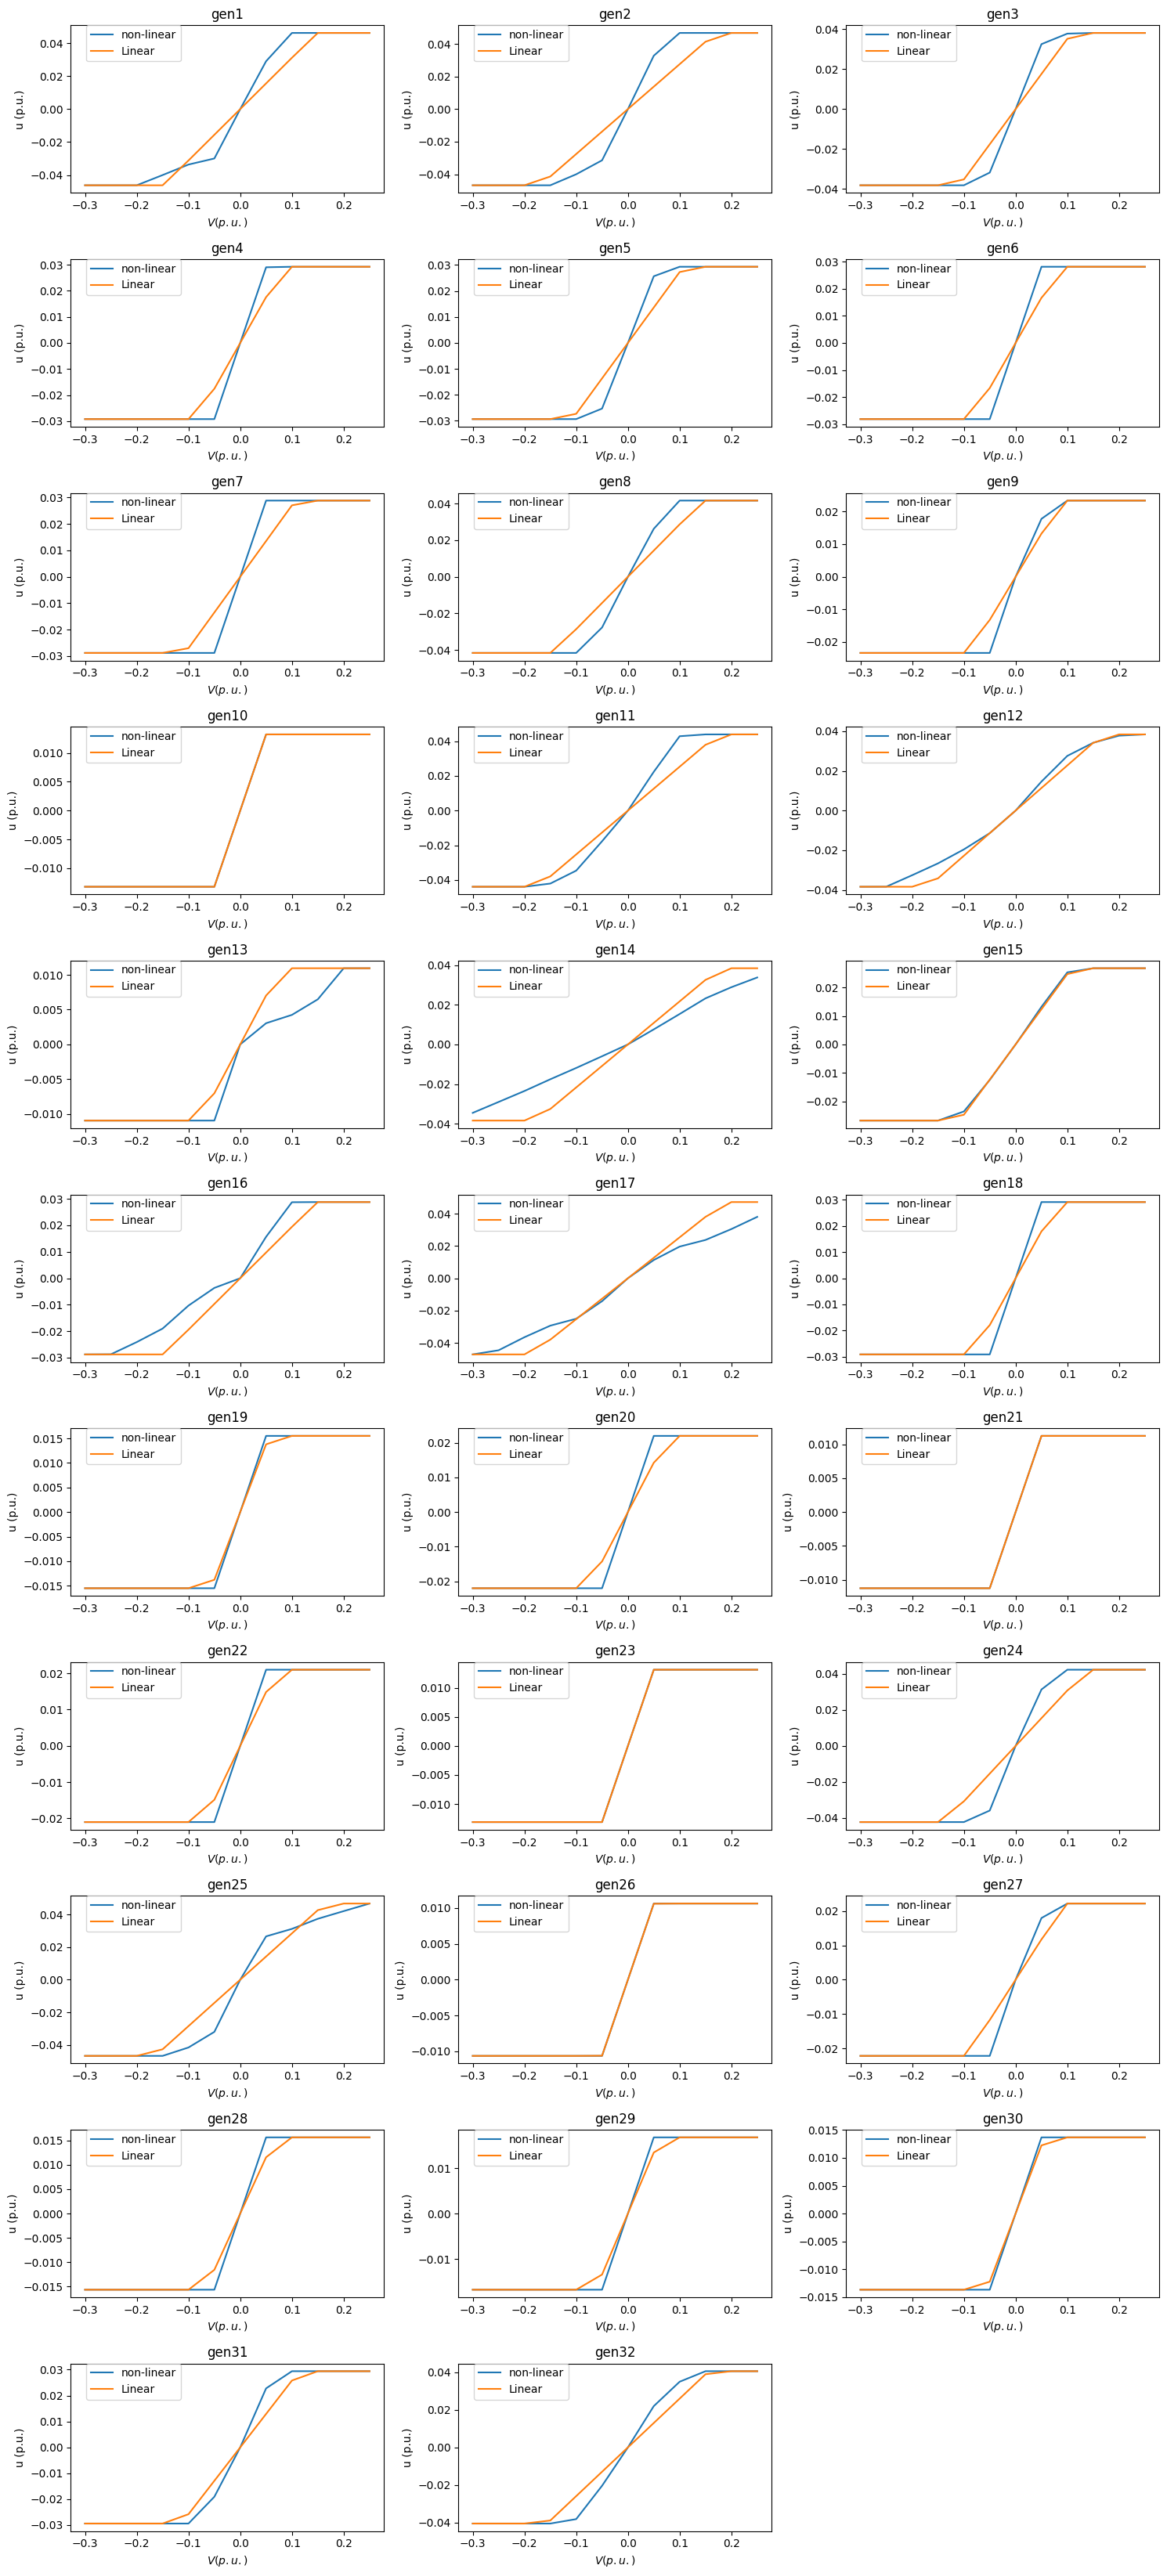

In [ ]:
s_concate0=np.random.uniform(-0.03,0.03,(1,n)).astype(np.float32)
state_w=np.arange(-0.3,0.3,0.05,dtype=np.float32)
action_dw=np.zeros(len(state_w))
action_dw_linear=np.zeros(len(state_w))

fig=plt.figure(figsize=(15,int(np.ceil(n/3))*3), dpi=100)
plt.subplot(2,2,1)
for idx_plot in range(n):
    gen_idx=idx_plot
    s_concate=s_concate0.copy()
    for j in range(len(state_w)):
            s_concate[0,gen_idx]=state_w[j]
            u=decentralized_policy(np.array([state_w[j]]), actor_model_list[idx_plot], 0*sigma_e[idx_plot],\
                                                  action_upper_bound[idx_plot], action_lower_bound[idx_plot])             
            u_linear= decentralized_policy(np.array([state_w[j]]), linear_actor_model_list[idx_plot], 0*sigma_e[idx_plot],\
                                                  action_upper_bound[idx_plot], action_lower_bound[idx_plot]) #actor_model_list[idx_plot]( np.array([prev_state[idx_plot]]) , training=True) 
            action_dw[j]=u
            action_dw_linear[j]= u_linear
    plt.subplot(np.ceil(n/3),3,idx_plot+1)
    plt.plot(state_w,action_dw, label='non-linear')
    plt.plot(state_w,action_dw_linear, label='Linear')
    plt.title('gen'+str(idx_plot+1))
    plt.xlabel('$V (p.u.)$')
    plt.ylabel('u (p.u.)') 
    plt.legend(bbox_to_anchor=(0.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()    


## simulate

Text(0.5, 0.98, 'nonlinear controller')

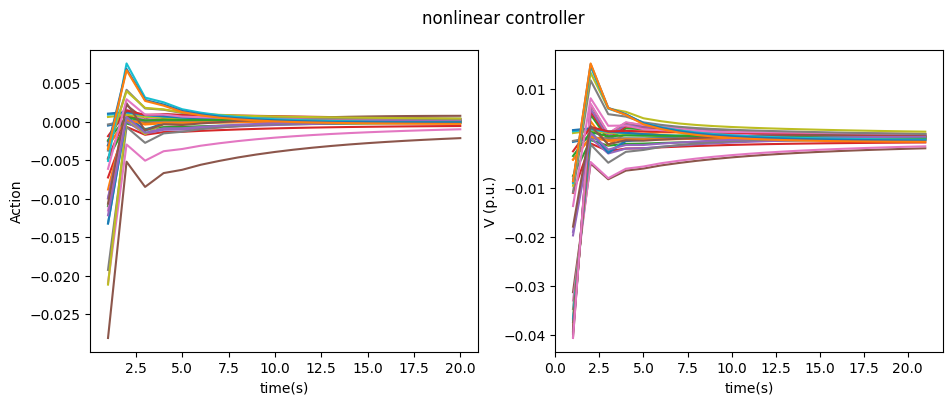

In [ ]:
# Plot the trajectory to visulize the performance of control
# plot dynamics for neural network controller

initial_state_q = (1- np.random.uniform(-Q_init_ratio,Q_init_ratio,(1,n)))*(Q_ref.T)
initial_state_p = (1- np.random.uniform(-P_init_ratio,P_init_ratio,(1,n)))*(P_ref.T)
s_concate=initial_state_p@Matrix_R.T+initial_state_q@Matrix_X.T

SimulationLength=20

actor_loss = np.zeros(n)
action = np.zeros((1, n))
prev_state = s_concate.copy()
Record_u=[]
Record_s=[]
Record_s.append(prev_state)
for t in range(SimulationLength):

    for agent_ind in range(n):
        action[:,agent_ind] = decentralized_policy(prev_state[:,agent_ind].reshape((-1,1)), actor_model_list[agent_ind], 0*sigma_e[agent_ind],\
                                                  action_upper_bound[agent_ind], action_lower_bound[agent_ind]) #actor_model_list[agent_ind]( np.array([prev_state[agent_ind]]) , training=True) 
    state = prev_state - action @ (X.T)
    prev_state = state.copy()
    Record_s.append(prev_state)
    Record_u.append(action.copy())


Record_u=np.squeeze(np.asarray(Record_u))
Record_s=np.squeeze(np.asarray(Record_s))

plt.figure(figsize=(11,4), dpi=100)

TimeRecord=np.arange(1,SimulationLength+1)

plt.subplot(1,2,1)
plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')


TimeRecord=np.arange(1,SimulationLength+2)
plt.subplot(1,2,2)
plt.plot(TimeRecord,Record_s)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')
plt.suptitle('nonlinear controller')


Text(0.5, 0.98, 'linear controller')

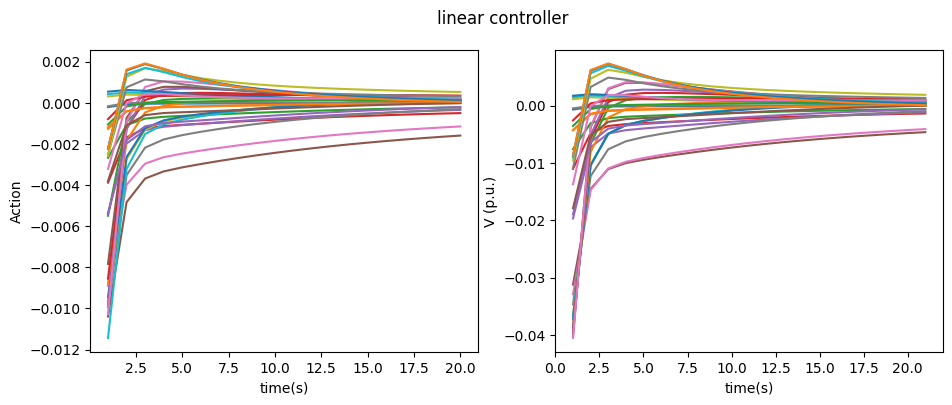

In [ ]:
# plot dynamics for linear controller
actor_loss = np.zeros(n)
action = np.zeros((1, n))
prev_state = s_concate.copy()
Record_u=[]
Record_s=[]
Record_s.append(prev_state)
for t in range(SimulationLength):

    for agent_ind in range(n):
        action[:,agent_ind] = decentralized_policy(prev_state[:,agent_ind].reshape((-1,1)), linear_actor_model_list[agent_ind], 0*sigma_e[agent_ind],\
                                                  action_upper_bound[agent_ind], action_lower_bound[agent_ind]) #actor_model_list[agent_ind]( np.array([prev_state[agent_ind]]) , training=True) 
    state = prev_state - action @ (X.T)
    prev_state = state.copy()
    Record_s.append(prev_state)
    Record_u.append(action.copy())


Record_u=np.squeeze(np.asarray(Record_u))
Record_s=np.squeeze(np.asarray(Record_s))

plt.figure(figsize=(11,4), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
plt.subplot(1,2,1)
plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')


TimeRecord=np.arange(1,SimulationLength+2)
plt.subplot(1,2,2)
plt.plot(TimeRecord,Record_s)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')
plt.suptitle('linear controller')
